In [1]:
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import random
import networkx as nx
from copy import deepcopy

random.seed(42)

# Exploring spread of COVID-19 pandemic across different networks with different interaction patterns

### Author: <em>Stefan Kotevski</em> - <em>Stefan.Kotevski@students.finki.ukim.mk</em>

### Date: <em>2021, January</em>

## Mentors:

### <em>Miroslav Mircev</em>
    
### <em>Lasko Basnarkov</em>

<br />
<br />
<br />


## 1 Introduction

With the arrival of the COVID-19 pandemic research into the spread and containment of the virus has been booming. Many estimations and simulations have been conducted in order to predict and shif the outcome. What I try to analyize and test in this project is how small alterations in behaviour patterns of members of a community affect the propagation of the infection. I want to mainly focus on the myth that contacting people in a closed group on a regular basis is safer as opposed to regular bahaviour where people meet and interact with a much wider circle of acquaintences. As expected and proven by most SEIR models, the disease will spread quicker with respect to the degree of conectedness of the network, however I want to test how much quicker.


## 2 Methodology

For the simulations and experiments I have contructed two networked SEIR models which will help me test the hypothesis. The first is a model based on _Damir Vrabac Et al._ [\[1\]](https://arxiv.org/pdf/2011.11739.pdf). This is a discrete time step, probabilistic model that is based on calculating the probabilities of each node in the network to be present in each of the SEIR compartments. This model is adequate since it takes the network layout into account. The model is expresed in the formulas below.

<br />

## $s_i^{t+1} = (s_i^t - s_i^tv_i^t)$

## $e_i^{t+1} = e_i^t + s_i^tv_i^t - \sigma e_i^t$

## $p_i^{t+1} = p_i^t + \sigma e_i^t - \gamma p_i^t$

## $r_i^{t+1} = r_i^t + \gamma p_i^t$

## $v_i^t = \beta_E \sum\limits_{j\in N_i} a_{ij}e_j^t + \beta \sum\limits_{j\in N_i} a_{ij}p_j^t $

<br />

The $s_i^t$ variables represent the probability of node **_i_** to be in the susceptible state at time step **_t_**. The $e_i^t$, $p_i^t$ and $r_i^t$ variables represent the probabilities for the node to be in the exposed, infected and recovered states at time **_t_** respectively. The adjecency matrix ***A*** of the node network, is represented by its elements as $a_{ij}$. All the other parameters are characteristics of the disease and have been sourced online. The $\beta$, $\beta_E$, $\sigma$ and $\gamma$ parameters estimate the rate of exposure, infection, incubation and recovery of the virus on a global scale respectively.

While this provides a suitable method for estimating what portion of the population will be in each of the compartements at any time step it is an ideal version that estimates only the probabilities without actually transitioning nodes from compartment to compartement. This is why I also implemented another model that I used to run actual simulations. The idea is that at each time step, there is a chance for an interaction to happen between neighbours. The probability for this happening is based on the edge weight between the nodes and this is the parameter that is used to model the different behaviour paterns. After this I use the disease parameters, $\beta$, $\beta_E$, $\sigma$ and $\gamma$ to bias the decision for transitioning into another SEIR state. The model is mostly based on prof.Leonid Zhukov's video [\[2\]](https://youtu.be/6pneK0tN1-I?t=3422).

I run both simulations on the same graph and compare the results. 
The variations in the behaviour paterns of nodes in the network is discussed in the following section.

## 2.1 Network generation

The most important part and the vaiable we are experimentig with is the network itself. The generation of the network i very important since it sits in the heart of the simulation algorithm. 

To represent and generate the networks of people I use the NetworkX library.

To controll the graph structure the parameters `min_community_size` and `max_community_size` are used. This parameters control the maximum and minimum degree of the nodes in the network.

I experimented with different graph structufes ranging from small world to grid graphs, however I feel that the most suitable graph to run tests on is the spatial graph. This is a network that connects local nodes togetner into fully conected components and then connect these components together with longer distance connections. This models human networks which are usually structured into smaller communities of friends that are communicating within the group and they all have outside acquaintences who they communicate less often with.

Using this structure I generated these communities with the `min_community_size` and `max_community_size` parameters. After generating the graph, the edges are given weights and this is the most importat step beacuse these wights model the communication behaviour of nodes. 

For the first type of network which I will refer to as the _Closed Community network_ I give higher probabilities of interaction to nodes which are inside the close friends group (fully connected component of the network) and lower probabilities of edges between these groups. This simulates the interactions inside and outside of the friendgroup. 

For the second network which I will refer to as the _Open Community network_, I use the same network, but modfy the edge wights to be a value in between the probability to communicate with friends and communicate with acqueintences from the _Closed Community network_. This simulates how people communicate when there is no pandemic, meaning that they are more likely to interact with paople who do not need to be in their closed community of friends. 

I also add some gaussian noise to make the probabilities varry a bit. These networks are then run through a few simulations with differen parameters for community size and number of initial exposed nodes. The results are recorded and ploted.

In [2]:
import itertools

def complete_graph_from_list(L, create_using=None):
    G = nx.empty_graph(len(L),create_using)
    if len(L)>1:
        edges = itertools.combinations(L,2)
        G.add_edges_from(edges)
    return G

def generate_community_graph(num_nodes, min_community_size, max_community_size, close_freq, acq_freq):
    total = 0
    G = nx.Graph()
    while total < num_nodes:
        x = random.randint(min_community_size, max_community_size)
        if x + total > num_nodes:
            x = num_nodes - total
        
        nodes = [i for i in range(total, total + x)]
        H = complete_graph_from_list(nodes)
        G.add_edges_from(H.edges, weight=close_freq)
        if total > 0:
            u = random.randint(0, total - 1)
            v = random.randint(total, total + x - 1)
            G.add_edge(u, v, weight=acq_freq)
            
        total += x
        
    return G

def generate_community_graph_more_conn(num_nodes, min_community_size, max_community_size, close_freq, acq_freq):
    total = 0
    G = nx.Graph()
    while total < num_nodes:
        x = random.randint(min_community_size, max_community_size)
        if x + total > num_nodes:
            x = num_nodes - total
        
        nodes = [i for i in range(total, total + x)]
        H = complete_graph_from_list(nodes)
        G.add_edges_from(H.edges, weight=close_freq)
        if total > 0:
            u = random.randint(0, total - 1)
            v = random.randint(total, total + x - 1)
            G.add_edge(u, v, weight=acq_freq)
            u = random.randint(0, total - 1)
            v = random.randint(total, total + x - 1)
            G.add_edge(u, v, weight=acq_freq)
            
        total += x
        
    return G

def generate_connected_graph(num_nodes, min_community_size, max_community_size):
    w = []
    for i in range(num_nodes):
        x = random.randint(min_community_size, max_community_size)
        w.append(x)

    G = nx.expected_degree_graph(w, seed=42, selfloops=False)
    degrees = [i for i in range(num_nodes) if G.degree[i] == 0]
    for i in degrees:
        other = random.randint(0, num_nodes)
        G.add_edge(i, other)
    
    H = nx.Graph()
    H.add_edges_from(G.edges, weight=0.4)
        
    return H

def plot_graph(G, save_plot=False, filename=''):
    fig, ax = plt.subplots(figsize=(18,10))
    node_color = [colors[x - 1] for x in nx.get_node_attributes(G, "state").values()]
    pos = nx.spring_layout(G, seed=42)
    states = list(states_dict.keys())
    for i in range(len(states_dict)):
        node_subset = [x for x, y in G.nodes(data=True) if y["state"]==i+1]
        nx.draw_networkx_nodes(G, pos=pos, ax=ax, nodelist=node_subset, node_size=100,
                               node_color=colors[i], label=states[i], alpha=.6)
    nx.draw_networkx_edges(G, pos=pos, ax=ax, edge_color="#a2a2a2", alpha=.6)
    plt.ioff()
    if save_plot:
        plt.savefig(filename)
        
def plot_results(susceptible, exposed, infected, recovered, num_days, title=None):
    fig = plt.figure(figsize=(18,10))
    plt.plot(range(num_days), susceptible, c=colors[0])
    plt.plot(range(num_days), exposed, c=colors[1])
    plt.plot(range(num_days), infected, c=colors[2])
    plt.plot(range(num_days), recovered, c=colors[3])
    states = list(states_dict.keys())
    plt.legend(states)
    if title:
        plt.title(title)
    else:
        plt.title(f"SEIR simulation after {num_days-1} days")
        
    plt.show()

# 3 Running the simulations

The simulation is implemented in the `run_simulation()` method below. It is an iterative method that transitons nodes from one state of the SEIR model into the next in a stohastic manner in each time step (in this case days). It acts like a discrete stohastic Markov process. It also progresses the probabilities of each node being in each of the SEIR compartements as mentioned in the beginning. In the end the probabilities are averaged and the population is devided among the compartments.

In the first bootstrapping phase a set of random nodes is initialized as exposed in order to kickstart the transition.

In the end the results from both simulations are plotted and the results are returned along with the new graph. I return the graph in the end for plotting and because each state coresponds to a color so this can be used to create a visualization of the results.

In [79]:
states_dict = {"susceptible": 1, "exposed": 2, "infected": 3, "recovered": 4}
colors = ["blue", "orange", "red", "green"]

def run_simulation(G, num_days, num_initial_exposed, params, check_relation=False, plot=True, save_plots=False, do_print=False, save_name=''):
    num_nodes = len(G.nodes)
    
    susceptible_nodes = []
    
    # Generates a list of unique random integers in the range of our nodes count
    exposed_nodes = random.sample(range(0, num_nodes-1), num_initial_exposed)
    infected_nodes = []
    recovered_nodes = []
    
    # Parameters of model
    beta, beta_e, sigma, gamma = params
    
    initial_state = []
    # Setting random nodes as initial exposed and others as susceptible and setting initial probabilities
    for i in range(num_nodes):
        probabilities = dict()
        if i in exposed_nodes:
            G.nodes[i]['state'] = states_dict['exposed']
            probabilities = {'s': 0.9, 'e': 0.1, 'i': 0.0, 'r': 0.0}
        else:
            G.nodes[i]['state'] = states_dict['susceptible']
            susceptible_nodes.append(i)
            probabilities = {'s': 1.0, 'e': 0.0, 'i': 0.0, 'r': 0.0}
            
        initial_state.append(probabilities)
        
    # Initiating starting counts
    S = num_nodes - num_initial_exposed
    E = num_initial_exposed
    I = 0
    R = 0
    S_counts = [S]
    E_counts = [E]
    I_counts = [I]
    R_counts = [R]
    s_probs = []
    e_probs = []
    i_probs = []
    r_probs = []
    G_new = deepcopy(G)
    next_state = deepcopy(initial_state)
    end_day = num_days
    end_day_p = num_days
    first = True
    first_p = True
    # Starting simulation for [num_days] iterations
    for i in range(1, num_days + 1):
        # Copying graph so that nodes which transition don't influence the others in the same iteration
        G_old = deepcopy(G_new)
        current_state = deepcopy(next_state)
        for j in range(num_nodes):
            p_exposed_neighbors = 0.0
            p_infected_neighbors = 0.0
            total_weight= 0.0
            for n in G_old.neighbors(j):
                p_exposed_neighbors += G_old.edges[j, n]['weight'] * current_state[n]['e']
                p_infected_neighbors += G_old.edges[j, n]['weight'] * current_state[n]['i']
                total_weight += G_old.edges[j, n]['weight']
                
            p_exposed_neighbors /= total_weight
            p_infected_neighbors /= total_weight
            
            d_s = current_state[j]['s'] * (p_exposed_neighbors * beta_e + p_infected_neighbors * beta)
            d_e = sigma * current_state[j]['e']
            d_i = gamma * current_state[j]['i']
            
            next_state[j]['s'] = current_state[j]['s'] - d_s
            next_state[j]['e'] = current_state[j]['e'] + d_s - d_e
            next_state[j]['i'] = current_state[j]['i'] - d_i + d_e
            next_state[j]['r'] = current_state[j]['r'] + d_i
            #next_state[j] = normalize(next_state[j])
            
            G_new.nodes[j]["state"] = decide_next_node_state(G_old, j, beta, beta_e, sigma, gamma)
            if do_print:
                print(f"DAY: {i} -> {next_state[j]}")
            
        if save_plots and (i % 10 == 0 or i == num_nodes or i == 1):
            filename = f"images/{save_name}/graph_day_{i}.png"
            plot_graph(G_new, True, filename)
            plt.close()
            
        S, E, I, R = count_node_states(G_new)
        if E + I == 0 and first:
            first = False
            end_day = i
                
        S_counts.append(S)
        E_counts.append(E)
        I_counts.append(I)
        R_counts.append(R)
        
        sp, ep, ip, rp = calculate_avg_probabilities(next_state)

        if ep + ip <= 0.000001 and first_p:
            first_p = False
            end_day_p = i
        
        s_probs.append(int(sp * num_nodes))
        e_probs.append(int(ep * num_nodes))
        i_probs.append(int(ip * num_nodes))
        r_probs.append(int(rp * num_nodes))
        
    if plot:
        plot_results(S_counts, E_counts, I_counts, R_counts, num_days+1)
        plot_results(s_probs, e_probs, i_probs, r_probs, num_days, title="SEIR model results from stohastic simulation")
    
    return S_counts, E_counts, I_counts, R_counts, G_new, s_probs, e_probs, i_probs, r_probs, end_day, end_day_p

def count_node_states(G):
    S = E = I = R = 0
    for node, p in G.nodes(data=True):
        if p["state"] == states_dict['susceptible']:
            S += 1
        elif p["state"] == states_dict['exposed']:
            E += 1
        elif p["state"] == states_dict['infected']:
            I += 1
        else:
            R += 1
    
    return S, E, I, R

def calculate_avg_probabilities(state):
    s_probs = 0.0
    e_probs = 0.0
    i_probs = 0.0
    r_probs = 0.0
    for n in state:
        s_probs += n['s']
        e_probs += n['e']
        i_probs += n['i']
        r_probs += n['r']

    s_probs /= len(state)
    e_probs /= len(state)
    i_probs /= len(state)
    r_probs /= len(state)
    return s_probs, e_probs, i_probs, r_probs
    
def normalize(probabilities):
    sum_ = 0.0
    for p in probabilities.values():
        sum_ += p
    
    normalized = dict()
    for k in probabilities.keys():
        normalized[k] = probabilities[k] / sum_
        
    return normalized

def clamp(my_value, min_value, max_value):
    return max(min(my_value, max_value), min_value)

def decide_next_node_state(G, node, beta, beta_e, sigma, gamma):
    current_state = G.nodes[node]['state']
    rng = random.uniform(0.0, 1.0)
    if current_state == states_dict["susceptible"]:
        # Node is in S stage so it can transition onlu to E ann I
        for n in G.neighbors(node):
            if G.nodes[n]['state'] == states_dict["exposed"] or G.nodes[n]['state'] == states_dict["infected"]:
                interacted = random.uniform(0.0, 1.0)
                if interacted <= G.edges[node, n]['weight']:
                    infected = random.uniform(0.0, 1.0)
                    if infected <= beta_e:
                        return states_dict["exposed"]
                    elif infected <= beta_e + beta:
                        return states_dict["infected"]
        
        return states_dict["susceptible"]
    elif current_state == states_dict["exposed"]:
        # Node is in E stage so it can transition only to I
        if rng <= sigma:
            return states_dict["infected"]
        else:
            return states_dict["exposed"]
    elif current_state == states_dict["infected"]:
        # Node is in I stage so it can transition only to R
        if rng <= gamma:
            return states_dict["recovered"]
        else:
            return states_dict["infected"]
    else:
        # Node is in R stage so it can only stay in R
        return states_dict["recovered"]

## 3.1 Disease and Population Parameters

As I mentioned before, the disease parameters model the COVID-19 virus and represent probabilities of spreading the virus after an iteraction and how long it incubates and infects the host. These parameters I sourced online and they are global estimates since the virus behaves differently in some parts of the world. These parameters although important for accurate simulations, in these tests are not too crutial since the results are measured relative one to another and the same parameters are used for both types of networks.

For the community size I use the `num_nodes` parameter and i set it to 1000 for a reasonable simulation time. I also se the `num_days` parameter which represents how many time staps(iterations) the simulation will run. I set this to 365 in order to run more simulations and I feel that that is enough days to notice the difference between the two networks. I tested with bigger values and found that this is sufficient for accuracy and also good for execution time. 

In [109]:
avg_infectious_period = 14 # Days
avg_incubation_period = 5 # Days
beta_e = 0.1
beta = 0.08
sigma = 1 / avg_incubation_period
gamma = 1 / avg_infectious_period
num_nodes = 1000
num_days = 365

params = (beta, beta_e, sigma, gamma)

Here I calculate the average number of neightbours (either close friends of acquaintences) in order to balance the number of interactions to be similar in both the closed and open community networks. With this I can calculate the probability of interactions (network edge weights) for each model.

In [110]:
num_initial_exposed = 5
min_community_size = 3
max_community_size = 5

averages_f = []
averages_a = []
averages_r = []
for i in range(100):
    K = generate_community_graph_more_conn(num_nodes, min_community_size, max_community_size, close_friend_interactin_freq, acquaintence_interaction_freq)
    f = []
    a = []
    r = []
    for node in K.nodes:
        fi=0
        ai=0
        for n in K.neighbors(node):
            if K.edges[node, n]['weight'] == close_friend_interactin_freq:
                fi += 1
            else:
                ai += 1

        f.append(fi)
        a.append(ai)
        r.append(fi + ai)

    averages_f.append(np.mean(f))
    averages_a.append(np.mean(a))
    averages_r.append(np.mean(r))

print(np.mean(averages_f))
print(np.mean(averages_a))
print(np.mean(averages_r))

# 3.17 * 0.28 + 1.0 * 0.2 == 4.16*0.26
close_friend_interactin_freq = 0.28
acquaintence_interaction_freq = 0.2
untructured_interaction_freq = 0.26

3.1674400000000005
0.9958199999999999
4.163260000000001


In the lower code block I run the simulations 100 times and measure the difference of the number of ***susceptible*** and ***recovered*** nodes from both methods. I also see the day at which the spread ended (as indicated by no more infected or exposed nodes in the network). The results are printed below and they are quite interesting. I did this test to ensure that my results are consistent because it is a stohastic process and a sufficient sample size is required

In [116]:
num_initial_exposed = 5
min_community_size = 3
max_community_size = 5

ITERATIONS = 100

s_diff = []
r_diff = []
end_day_diff = []
end_day_diff_p = []

print(f"Running {ITERATIONS} iterations of the simulation to compare results\n")
for i in range(ITERATIONS):
    K = generate_community_graph_more_conn(num_nodes, min_community_size, max_community_size, close_friend_interactin_freq, acquaintence_interaction_freq)
    G = nx.Graph()
    G.add_edges_from(K.edges, weight=untructured_interaction_freq)
    S1, E1, I1, R1, H, sp1, ep1, ip1, rp1, end_day1, end_day_p1 = run_simulation(K, num_days, num_initial_exposed, \
        params, check_relation=True, plot=False, save_plots=False, do_print=False)
    S2, E2, I2, R2, L, sp2, ep2, ip2, rp2, end_day2, end_day_p2 = run_simulation(G, num_days, num_initial_exposed, \
        params, check_relation=True, plot=False, save_plots=False, do_print=False)
    s_diff.append(S1[-1] - S2[-1])
    r_diff.append(R1[-1] - R2[-1])
    end_day_diff.append(end_day1 - end_day2)
    end_day_diff_p.append(end_day_p1 - end_day_p2)

print(f"Mean of difference between susceptible nodes with simulated method: {np.mean(s_diff)}")
print(f"Mean of difference between recovered nodes with simulated method: {np.mean(r_diff)}")
print(f"Mean of difference between end day nodes with simulated method: {np.mean(end_day_diff)}")

Running 100 iterations of the simulation to compare results

Mean of difference between susceptible nodes with simulated method: 119.93
Mean of difference between recovered nodes with simulated method: -120.07
Mean of difference between end day nodes with simulated method: 1.52


## 3 Simulations

In this section i run a few experiments with different parameter variations and plot the results.

### 3.1 Changing the size od each group

In the first 3 runs of the experiments I change the `min_community_size` and `max_community_size` parameters and measure how fast the disease saturates each of the networks. Community sizes from 3-5, 5-7 and 5-10 members were used for each of the runs.

The very first run is used as a baseline

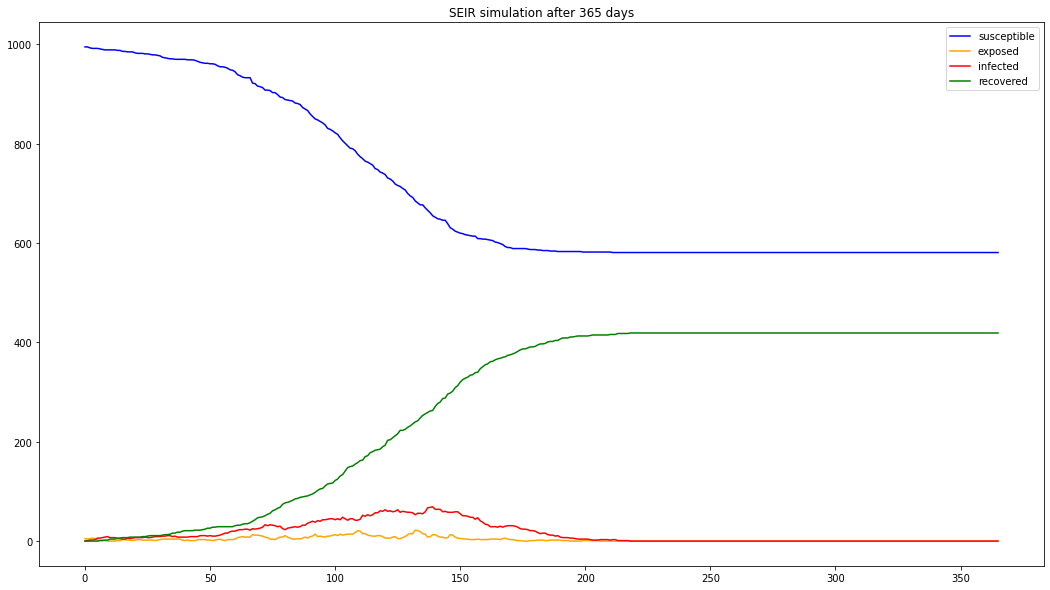

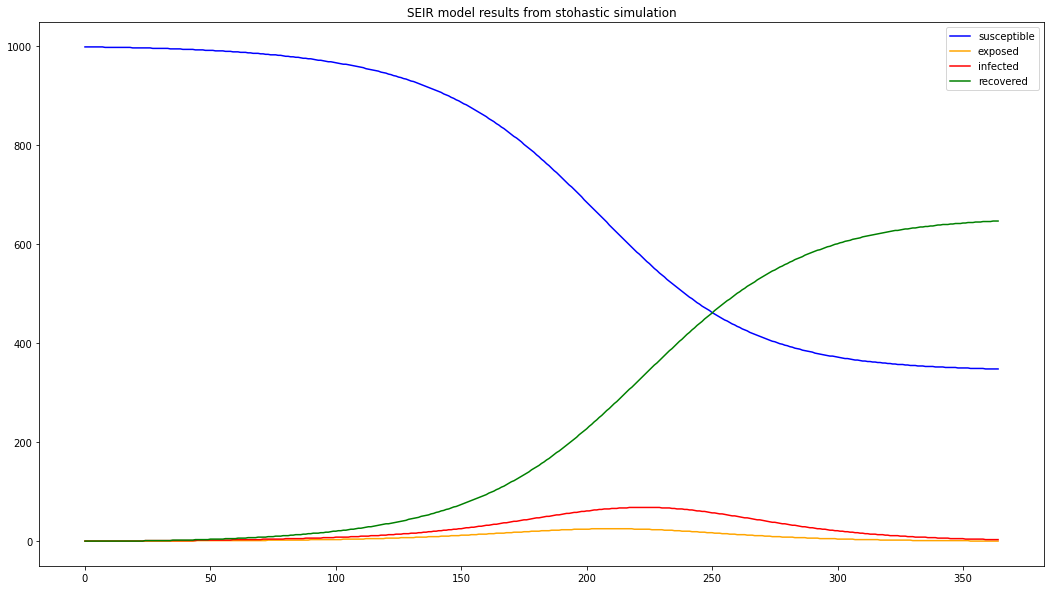

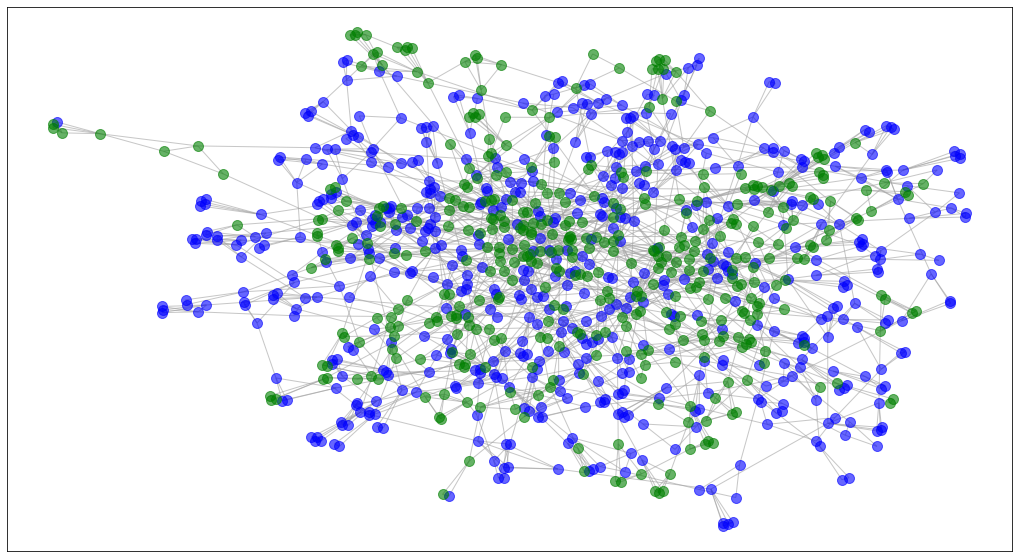

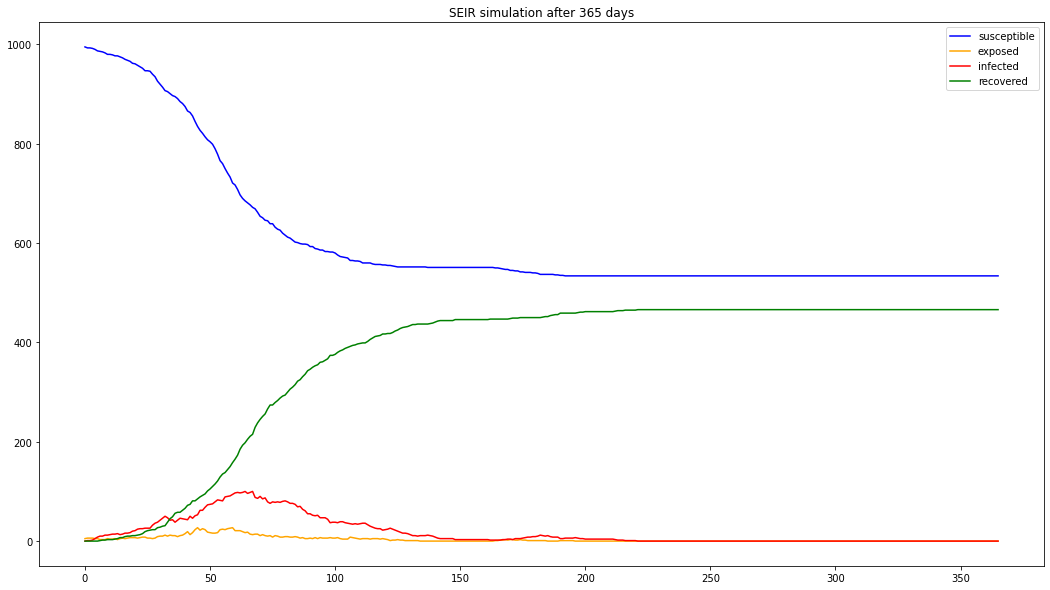

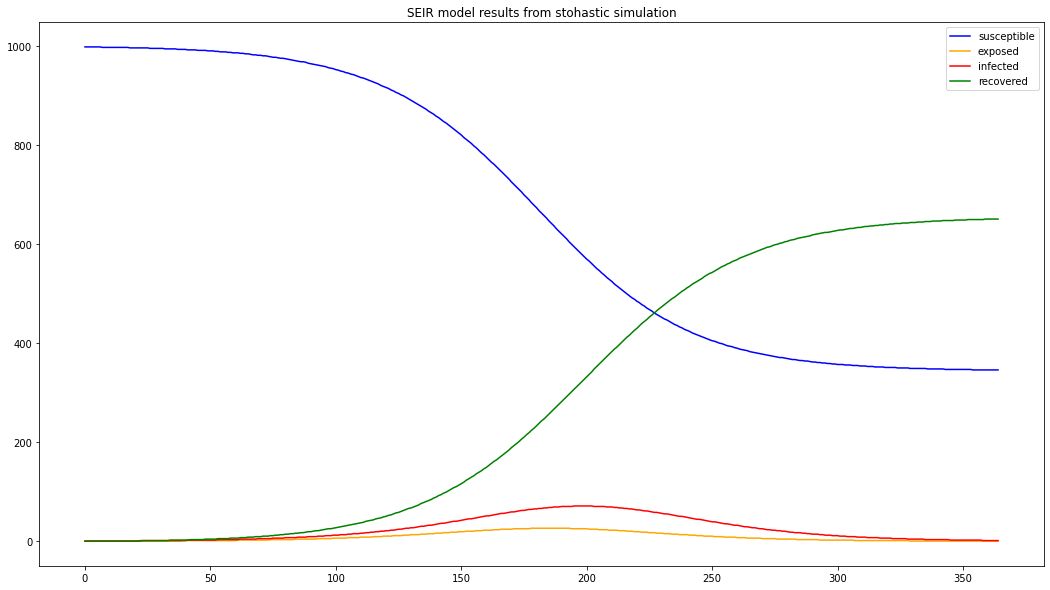

Susceptible nodes in closed community: 581 and open community: 534
Recovered nodes in closed community: 419 and open community: 466
End day in closed community: 218 and open community: 221


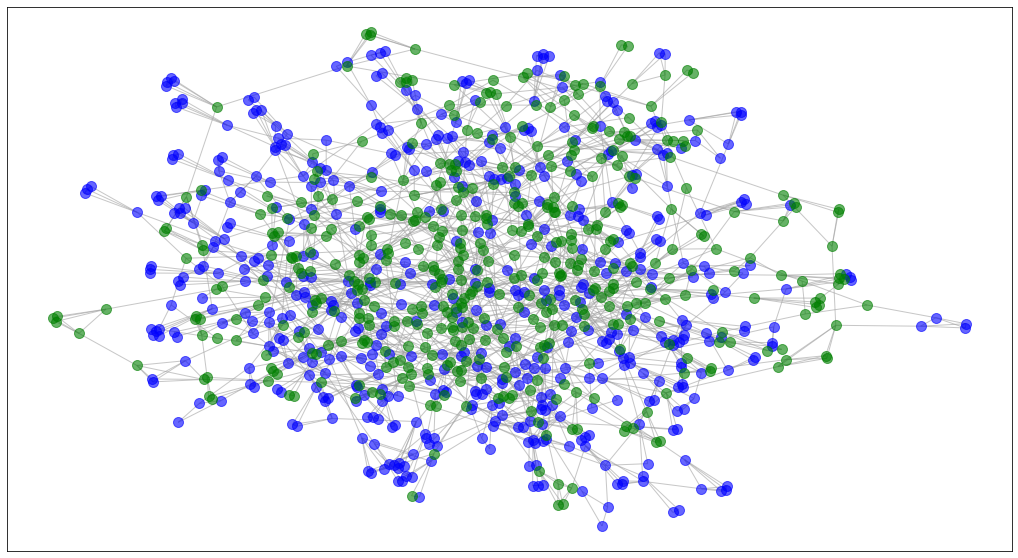

In [111]:
num_initial_exposed = 5
min_community_size = 3
max_community_size = 5

K = generate_community_graph_more_conn(num_nodes, min_community_size, max_community_size, close_friend_interactin_freq, acquaintence_interaction_freq)
G = nx.Graph()
G.add_edges_from(K.edges, weight=untructured_interaction_freq)

S1, E1, I1, R1, H, sp1, ep1, ip1, rp1, end_day1, end_day_p1 = run_simulation(K, num_days, num_initial_exposed, \
    params, check_relation=True, plot=True, save_plots=False, do_print=False)
plot_graph(H)
S2, E2, I2, R2, L, sp2, ep2, ip2, rp2, end_day2, end_day_p2 = run_simulation(G, num_days, num_initial_exposed, \
    params, check_relation=True, plot=True, save_plots=False, do_print=False)
plot_graph(L)

print(f"Susceptible nodes in closed community: {S1[-1]} and open community: {S2[-1]}")
print(f"Recovered nodes in closed community: {R1[-1]} and open community: {R2[-1]}")
print(f"End day in closed community: {end_day1} and open community: {end_day2}")

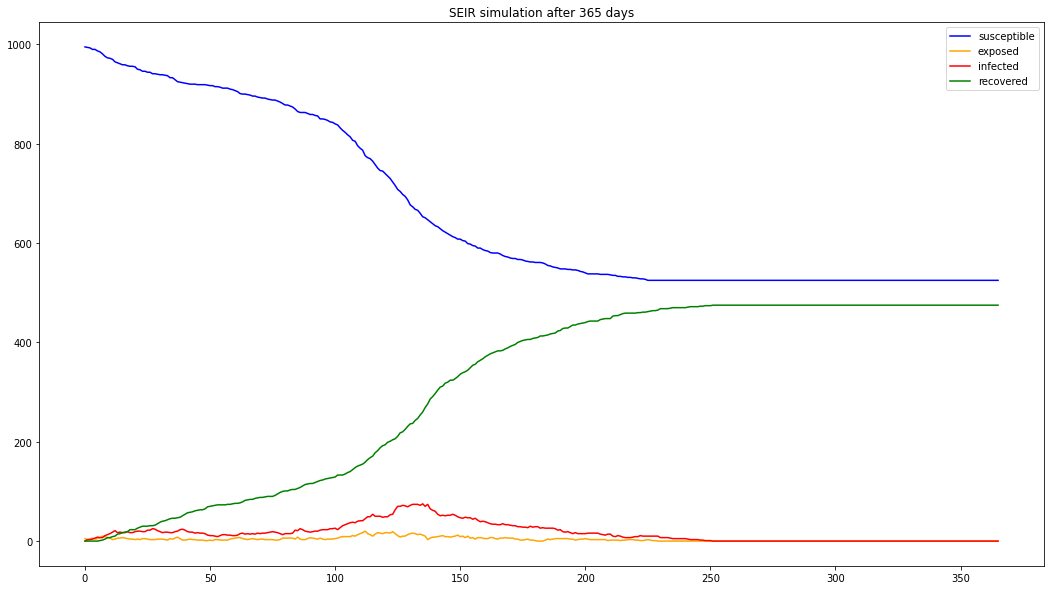

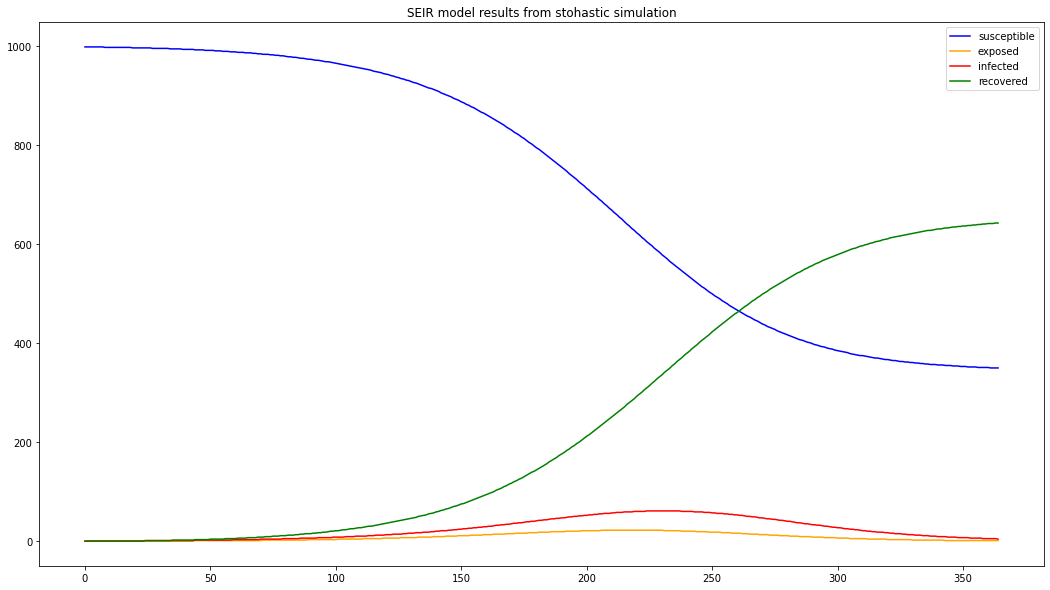

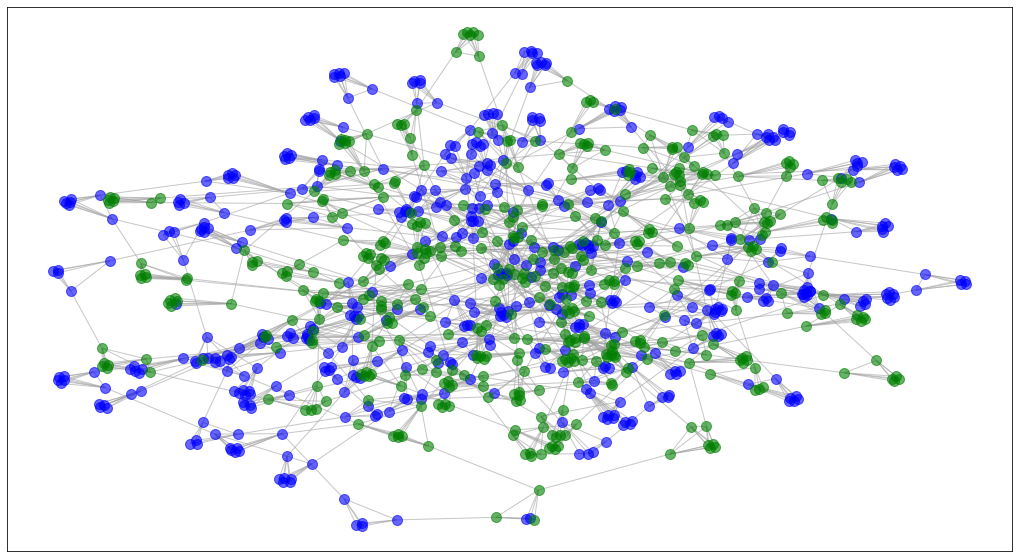

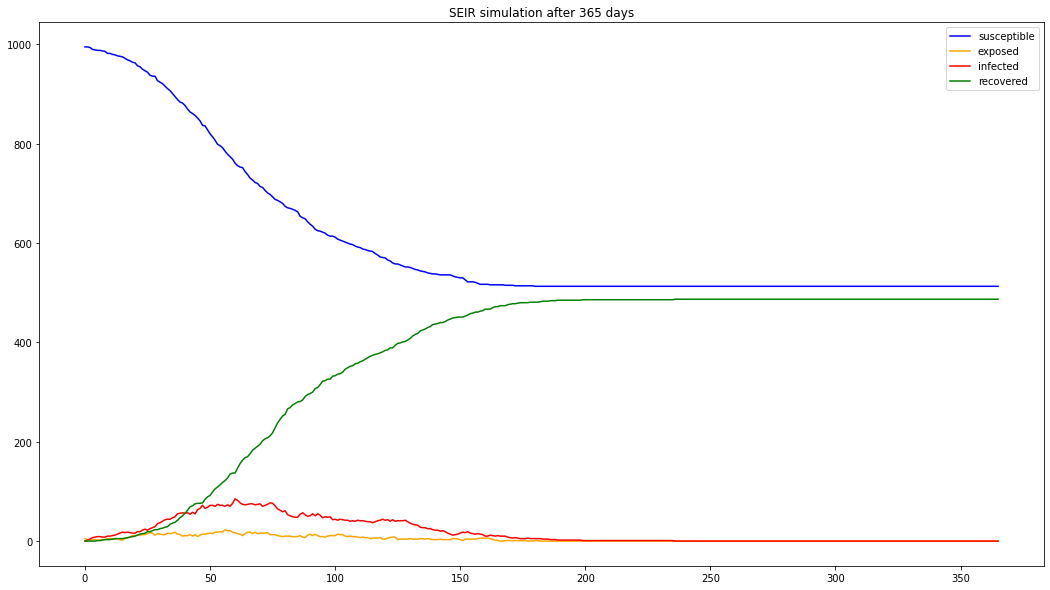

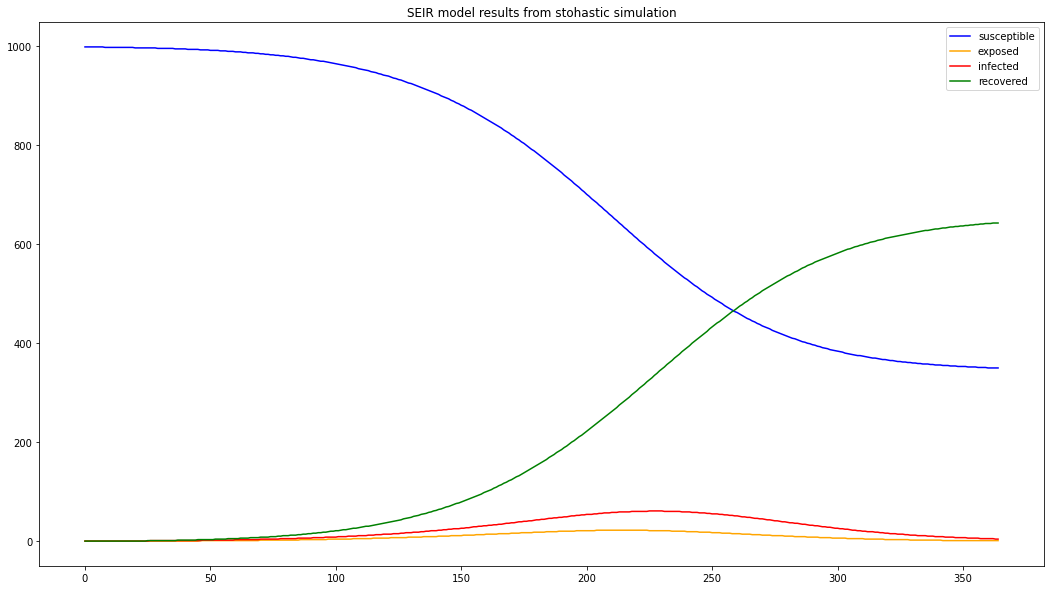

Susceptible nodes in closed community: 525 and open community: 513
Recovered nodes in closed community: 475 and open community: 487
End day in closed community: 251 and open community: 236


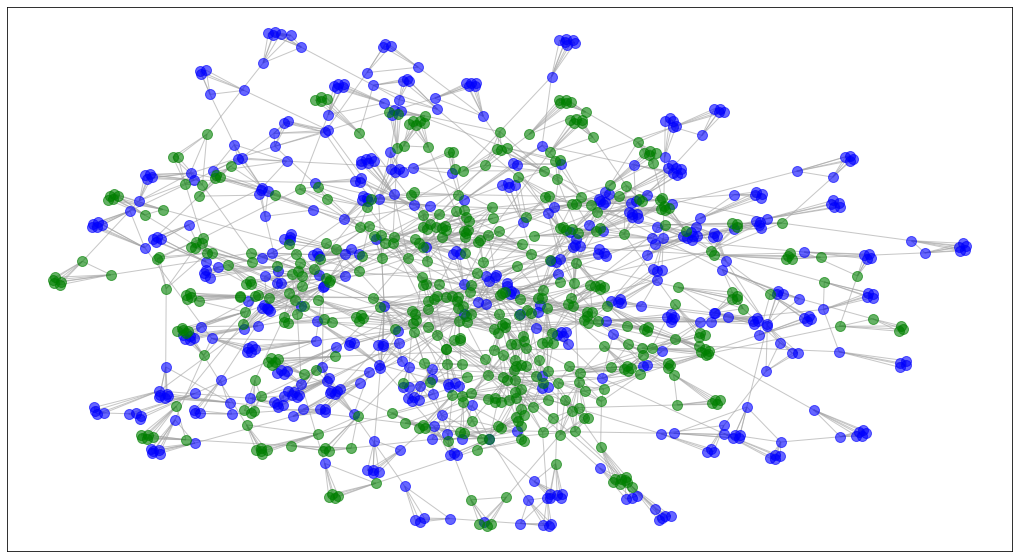

In [112]:
num_initial_exposed = 5
min_community_size = 5
max_community_size = 7

K = generate_community_graph_more_conn(num_nodes, min_community_size, max_community_size, close_friend_interactin_freq, acquaintence_interaction_freq)
G = nx.Graph()
G.add_edges_from(K.edges, weight=untructured_interaction_freq)

S1, E1, I1, R1, H, sp1, ep1, ip1, rp1, end_day1, end_day_p1 = run_simulation(K, num_days, num_initial_exposed, \
    params, check_relation=True, plot=True, save_plots=False, do_print=False)
plot_graph(H)
S2, E2, I2, R2, L, sp2, ep2, ip2, rp2, end_day2, end_day_p2 = run_simulation(G, num_days, num_initial_exposed, \
    params, check_relation=True, plot=True, save_plots=False, do_print=False)
plot_graph(L)

print(f"Susceptible nodes in closed community: {S1[-1]} and open community: {S2[-1]}")
print(f"Recovered nodes in closed community: {R1[-1]} and open community: {R2[-1]}")
print(f"End day in closed community: {end_day1} and open community: {end_day2}")

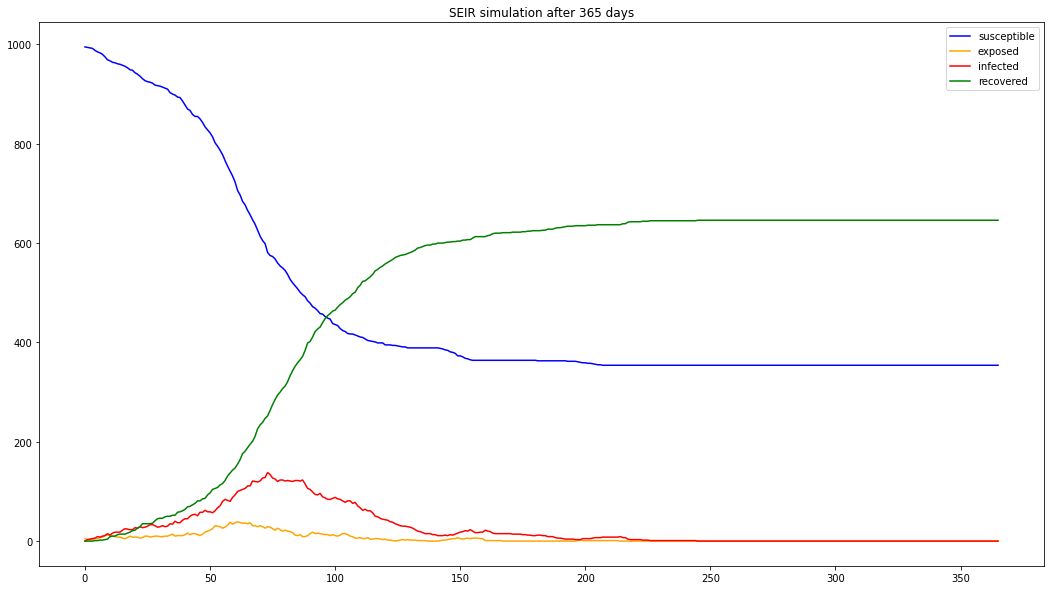

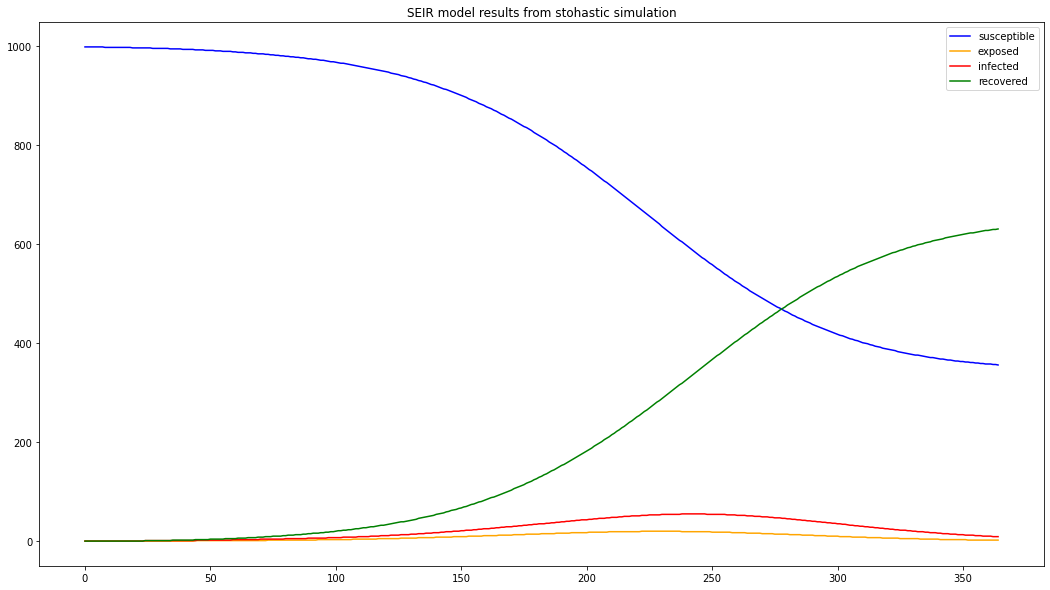

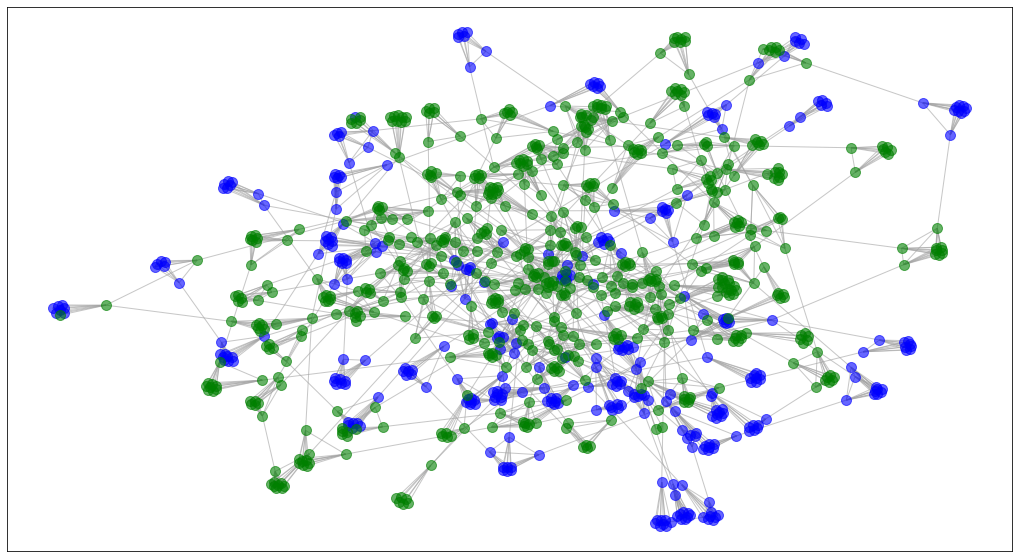

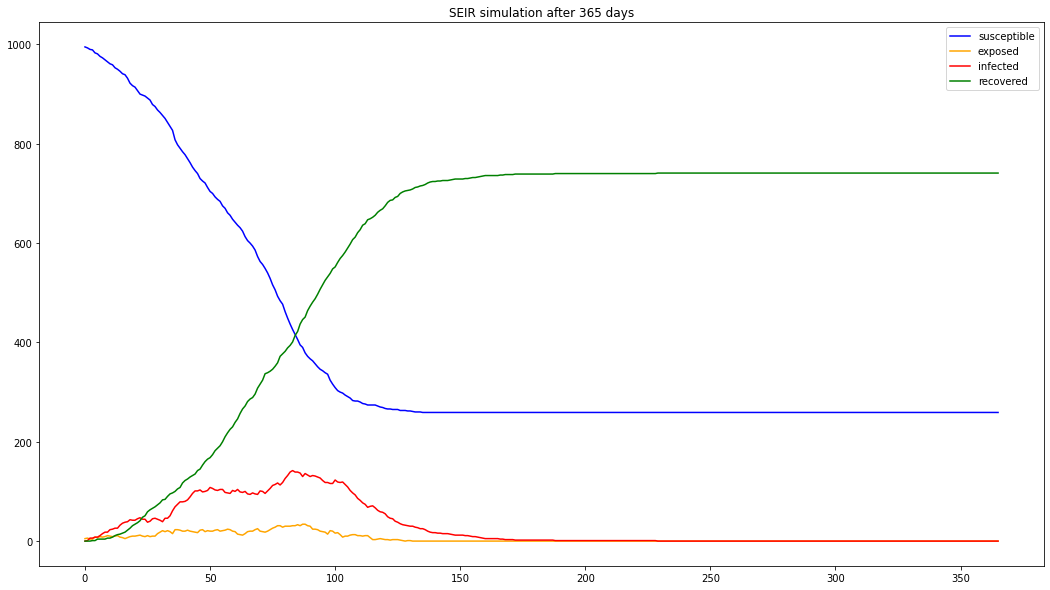

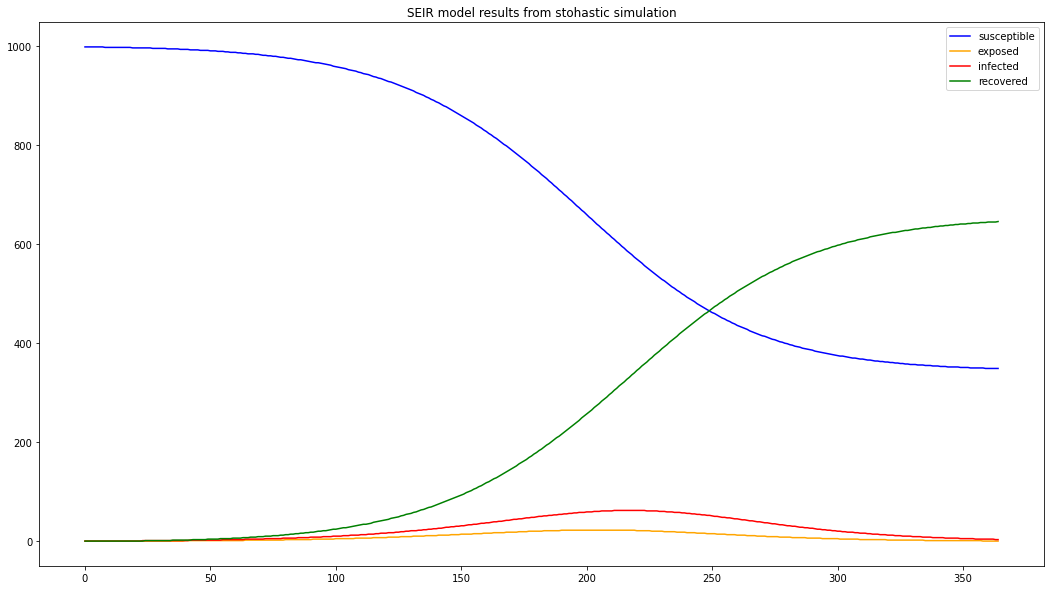

Susceptible nodes in closed community: 354 and open community: 259
Recovered nodes in closed community: 646 and open community: 741
End day in closed community: 245 and open community: 229


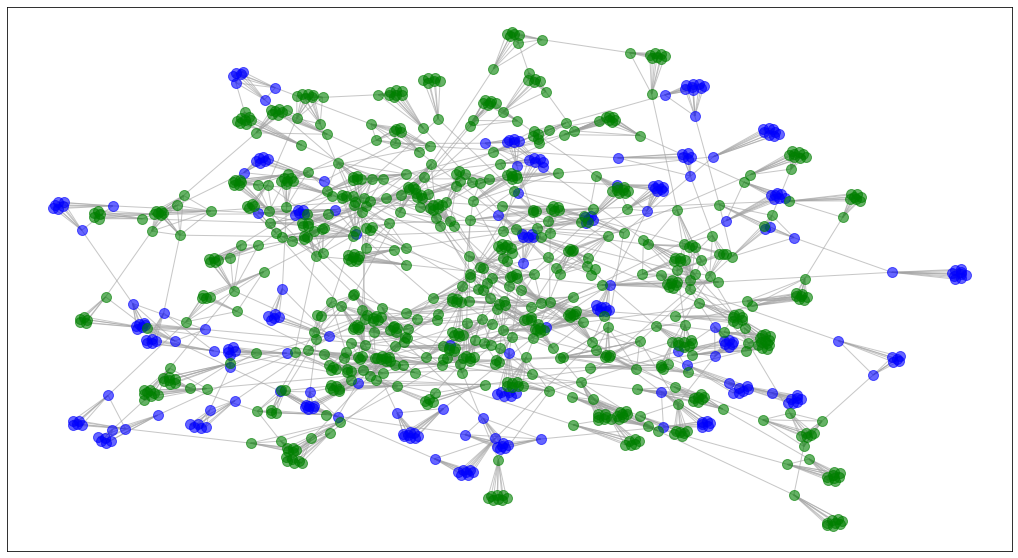

In [113]:
num_initial_exposed = 5
min_community_size = 7
max_community_size = 10

K = generate_community_graph_more_conn(num_nodes, min_community_size, max_community_size, close_friend_interactin_freq, acquaintence_interaction_freq)
G = nx.Graph()
G.add_edges_from(K.edges, weight=untructured_interaction_freq)

S1, E1, I1, R1, H, sp1, ep1, ip1, rp1, end_day1, end_day_p1 = run_simulation(K, num_days, num_initial_exposed, \
    params, check_relation=True, plot=True, save_plots=False, do_print=False)
plot_graph(H)
S2, E2, I2, R2, L, sp2, ep2, ip2, rp2, end_day2, end_day_p2 = run_simulation(G, num_days, num_initial_exposed, \
    params, check_relation=True, plot=True, save_plots=False, do_print=False)
plot_graph(L)

print(f"Susceptible nodes in closed community: {S1[-1]} and open community: {S2[-1]}")
print(f"Recovered nodes in closed community: {R1[-1]} and open community: {R2[-1]}")
print(f"End day in closed community: {end_day1} and open community: {end_day2}")

### 3.2 Changing the number of initial exposed

In this section I change the `num_initial_exposed` parameter. In the first run it is set lower than the baseline (from 5 to 3) and in the next one higher (from 5 to 10). This again obviously just speeds up or slows down convergence but what is interesting is thath the amount of change is  similar between all networks. I did many runs because the networks are randomly generated. I took average values so when that is taken into account, we can determine that even with this change the networks perform similarly relative one to other. Further results will be analyzed in the final section.

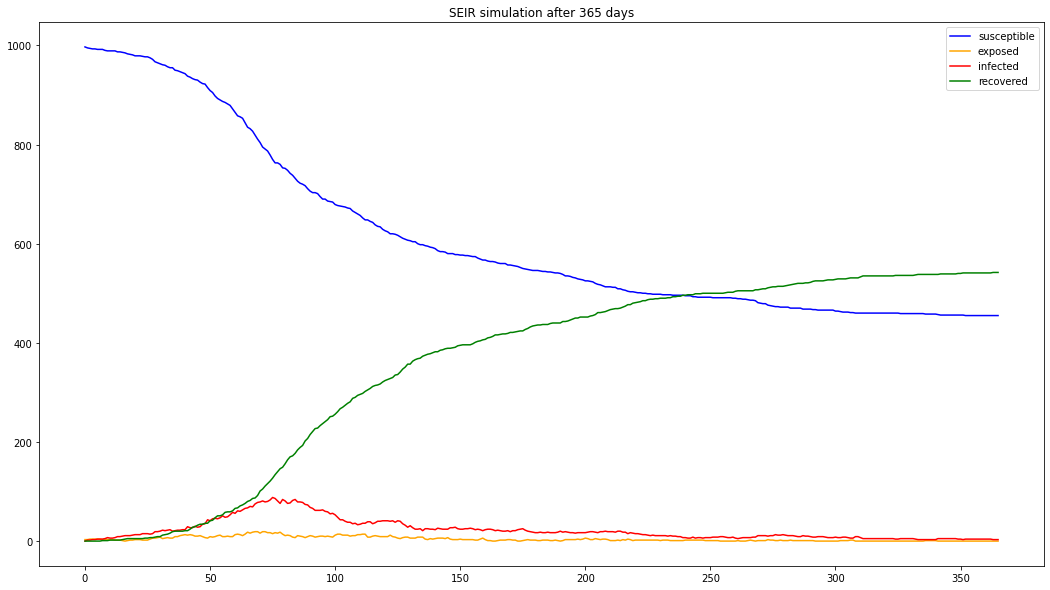

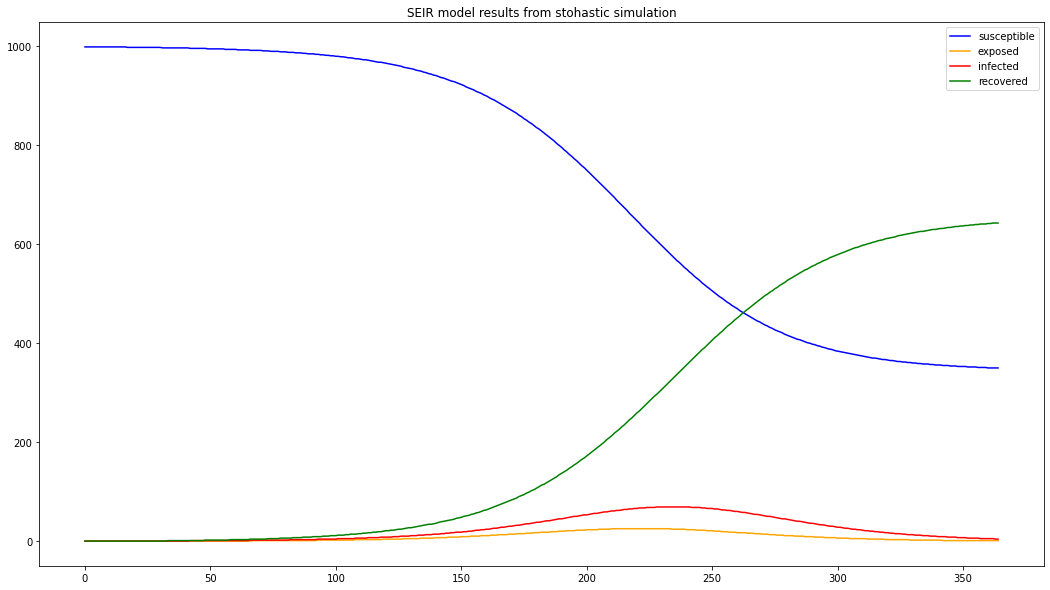

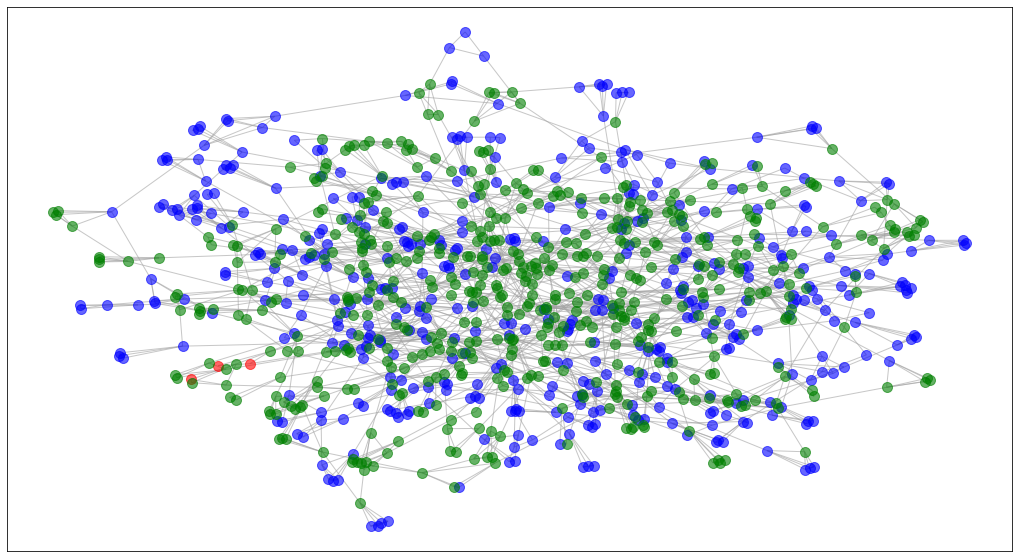

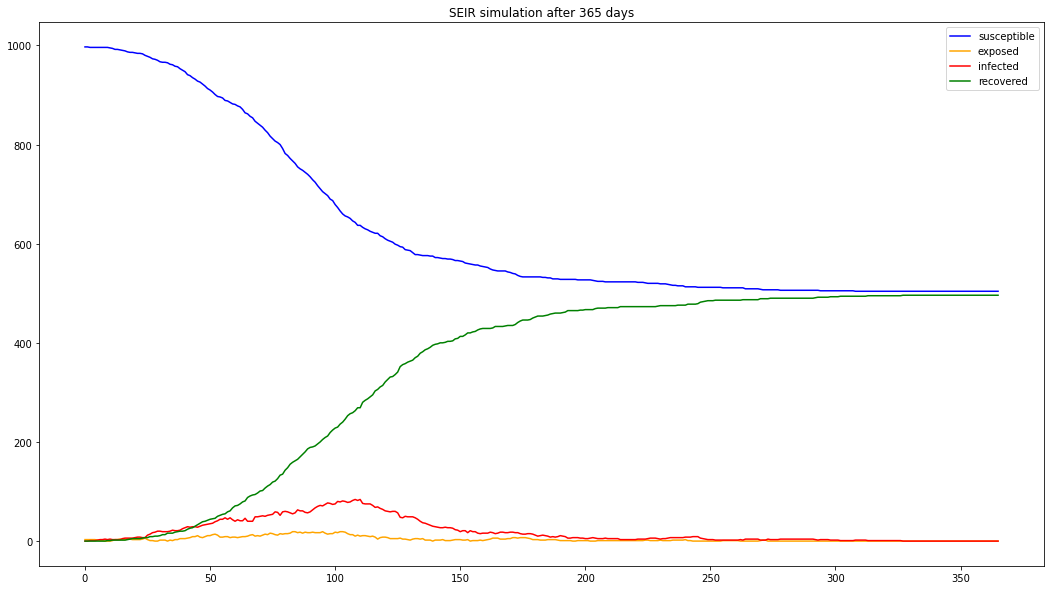

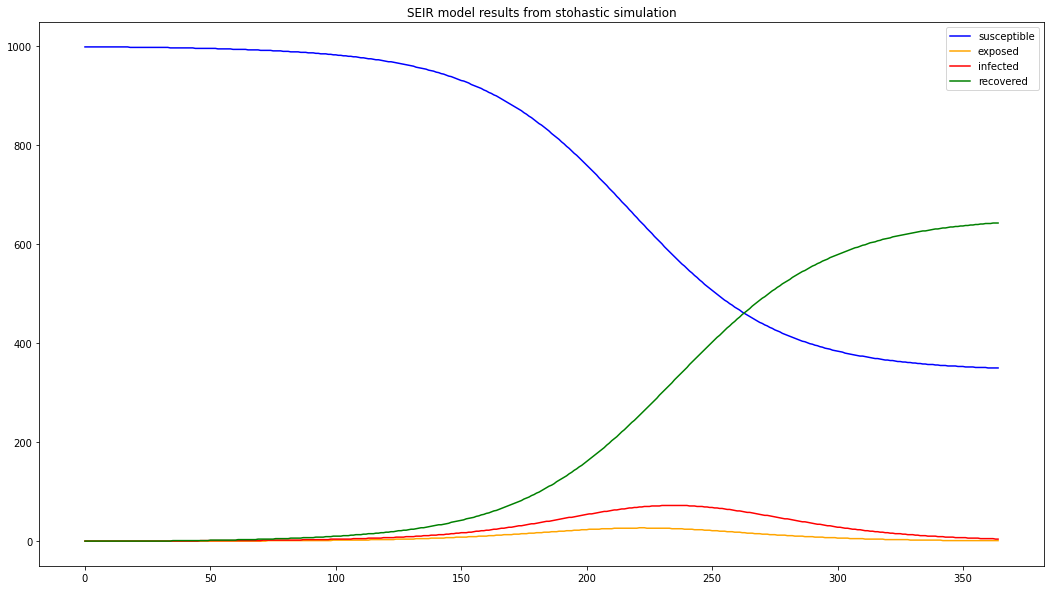

Susceptible nodes in closed community: 455 and open community: 504
Recovered nodes in closed community: 542 and open community: 496
End day in closed community: 365 and open community: 327


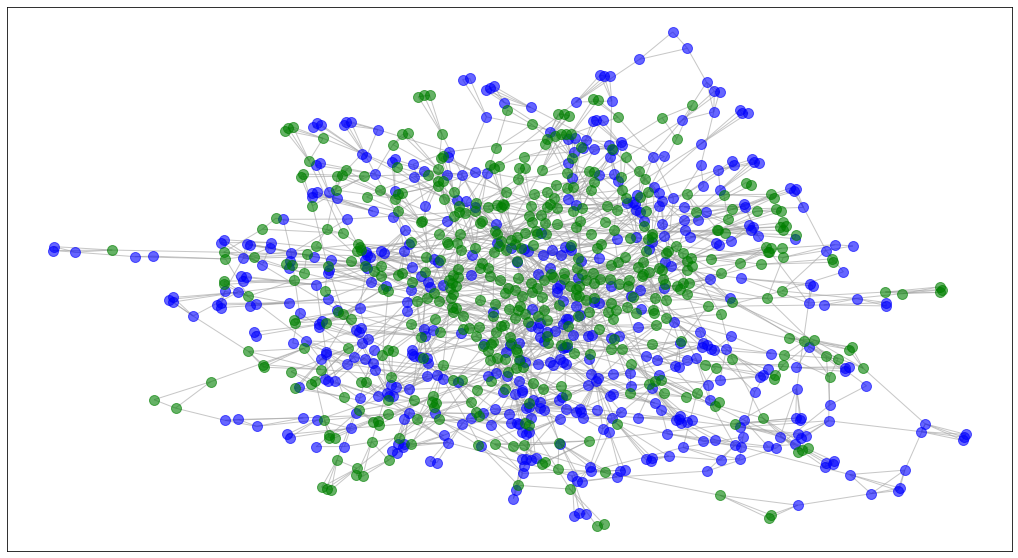

In [114]:
num_initial_exposed = 3
min_community_size = 3
max_community_size = 5

K = generate_community_graph_more_conn(num_nodes, min_community_size, max_community_size, close_friend_interactin_freq, acquaintence_interaction_freq)
G = nx.Graph()
G.add_edges_from(K.edges, weight=untructured_interaction_freq)

S1, E1, I1, R1, H, sp1, ep1, ip1, rp1, end_day1, end_day_p1 = run_simulation(K, num_days, num_initial_exposed, \
    params, check_relation=True, plot=True, save_plots=False, do_print=False)
plot_graph(H)
S2, E2, I2, R2, L, sp2, ep2, ip2, rp2, end_day2, end_day_p2 = run_simulation(G, num_days, num_initial_exposed, \
    params, check_relation=True, plot=True, save_plots=False, do_print=False)
plot_graph(L)

print(f"Susceptible nodes in closed community: {S1[-1]} and open community: {S2[-1]}")
print(f"Recovered nodes in closed community: {R1[-1]} and open community: {R2[-1]}")
print(f"End day in closed community: {end_day1} and open community: {end_day2}")

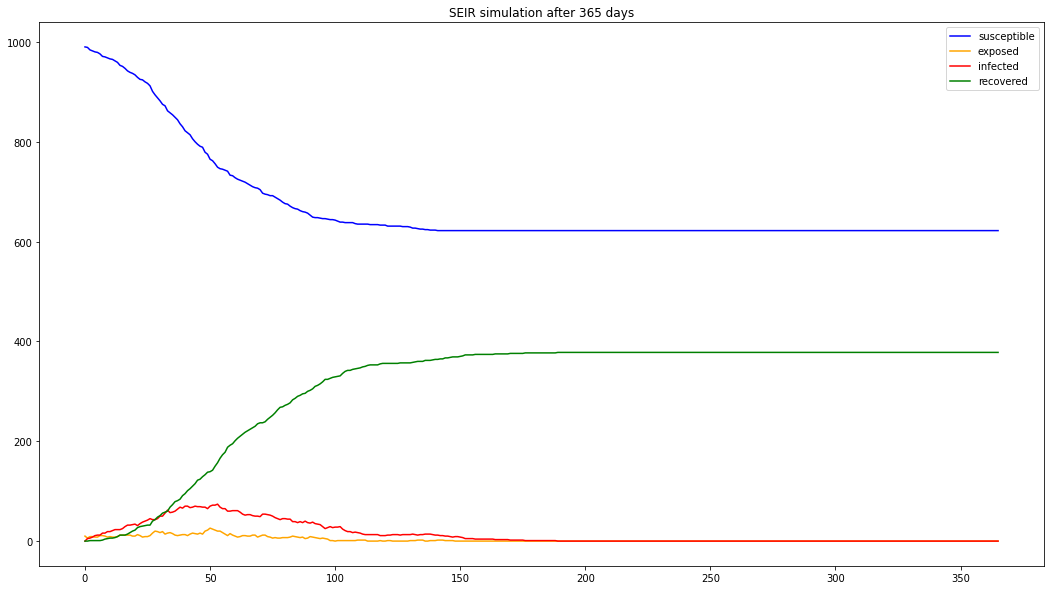

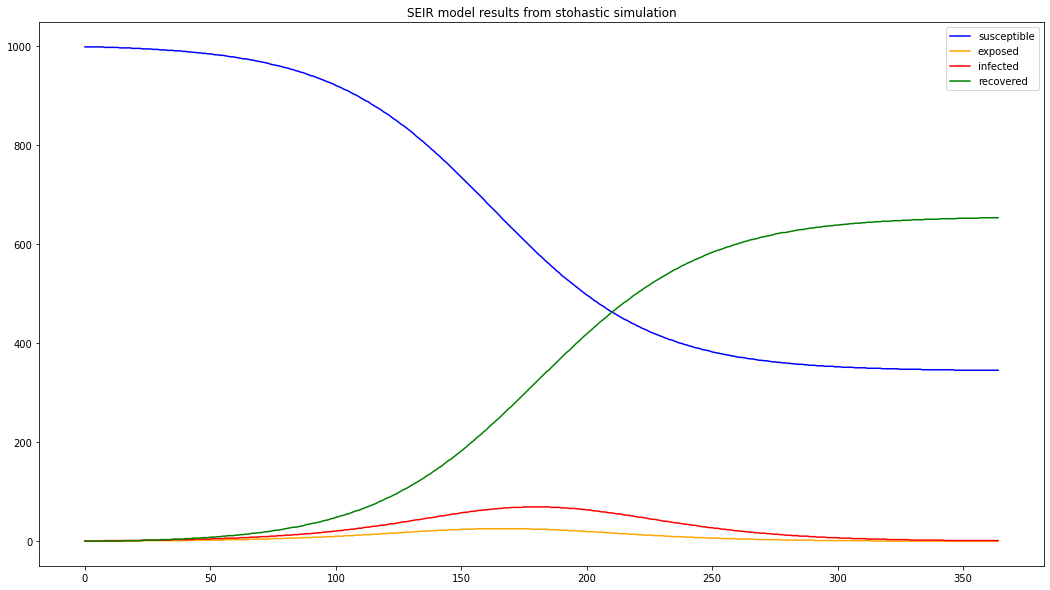

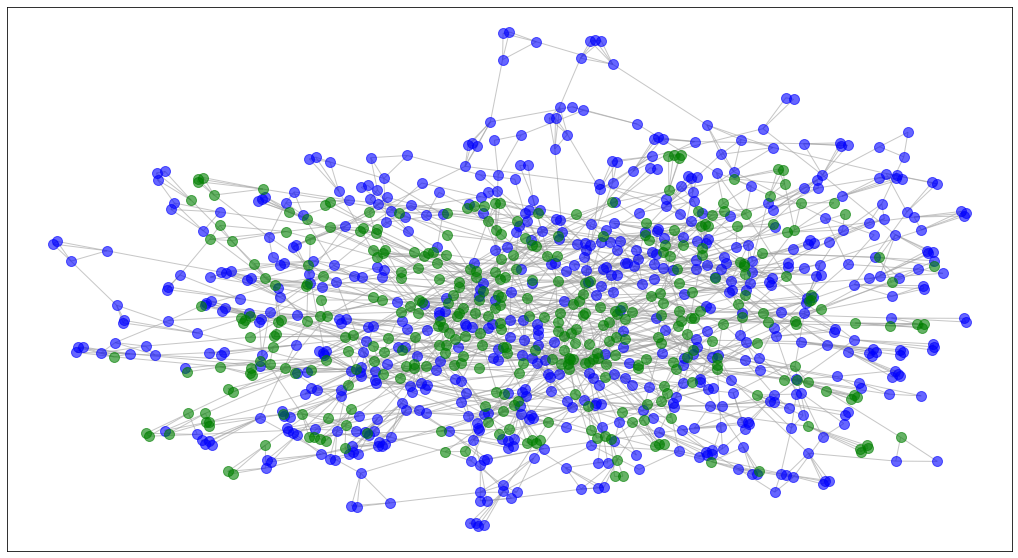

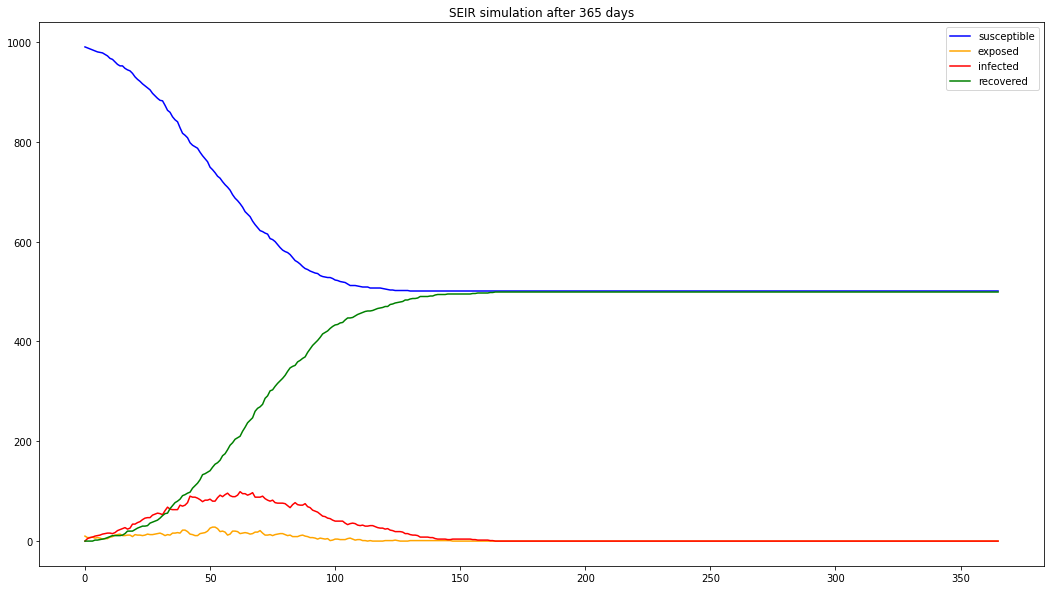

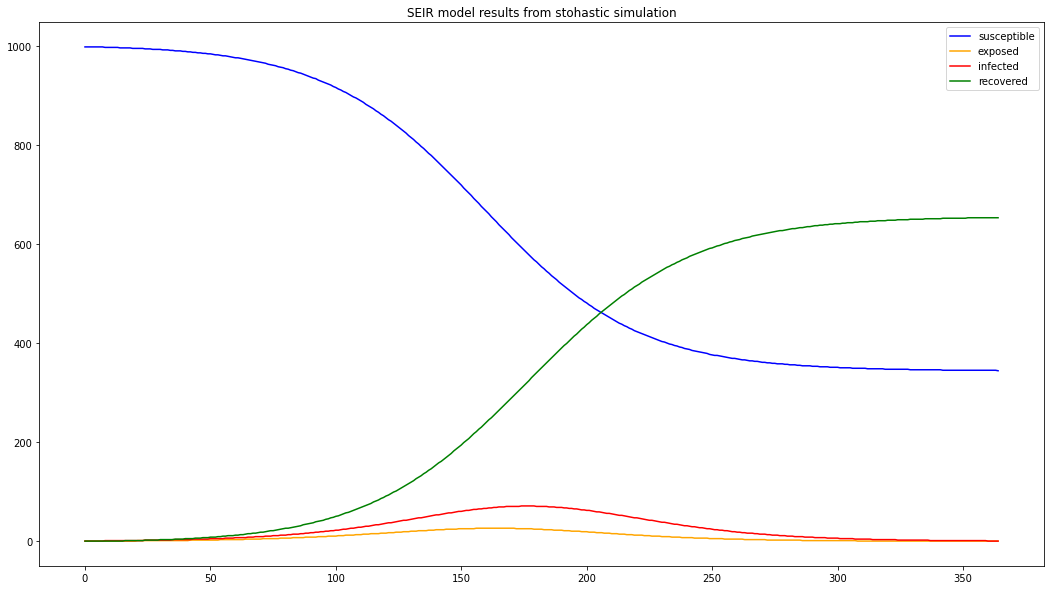

Susceptible nodes in closed community: 622 and open community: 501
Recovered nodes in closed community: 378 and open community: 499
End day in closed community: 189 and open community: 164


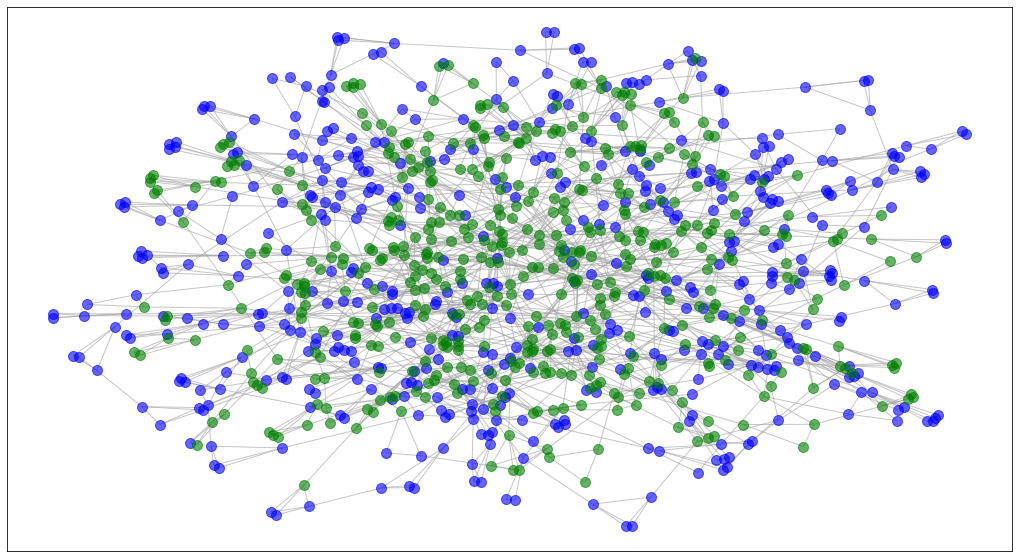

In [115]:
num_initial_exposed = 10
min_community_size = 3
max_community_size = 5

K = generate_community_graph_more_conn(num_nodes, min_community_size, max_community_size, close_friend_interactin_freq, acquaintence_interaction_freq)
G = nx.Graph()
G.add_edges_from(K.edges, weight=untructured_interaction_freq)

S1, E1, I1, R1, H, sp1, ep1, ip1, rp1, end_day1, end_day_p1 = run_simulation(K, num_days, num_initial_exposed, \
    params, check_relation=True, plot=True, save_plots=False, do_print=False)
plot_graph(H)
S2, E2, I2, R2, L, sp2, ep2, ip2, rp2, end_day2, end_day_p2 = run_simulation(G, num_days, num_initial_exposed, \
    params, check_relation=True, plot=True, save_plots=False, do_print=False)
plot_graph(L)

print(f"Susceptible nodes in closed community: {S1[-1]} and open community: {S2[-1]}")
print(f"Recovered nodes in closed community: {R1[-1]} and open community: {R2[-1]}")
print(f"End day in closed community: {end_day1} and open community: {end_day2}")

# 4 Results and Conclusion

As we can see in th results many of the resuts are quite suprising. The disease spread usually seems to go slower in the closed comunity network, however the difference is not too significant most of the time. There were even simulations where the virus spread faster in the closed community network. When runnin a 100 simulations with the first set of parameters, namely: numbaer of initial exposed: 5, min comunity size: 3 and max comunity size: 5, the averages show that most of the time the open comunity network had more susceptible nodes and lasted about 6 dayse less. I do not think that this difference is too significant, but it does demonstrate that the myth that interacting regulatly in a closed community is most likely false.

### Results table
![Results](assets/results.png)

### Closed Community Network
![Connected Net](assets/community_graph.gif)

### Open Community Network
![Coomunity Net 1](assets/random.gif)